In [10]:
# 验证路径设置
%matplotlib inline
import os
import sys
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import query_to_wechat


# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块

try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from dotenv import load_dotenv
    from IPython import get_ipython
    load_dotenv()  # 自动加载.env文件
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


['ark_example.py', 'deepseek.ipynb', 'query_to_wechat.py', 'sdk.log', 'temp_output.md', '__pycache__']


FileNotFoundError: [Errno 2] No such file or directory: './server_chan.env'

In [ ]:
# 下载股票数据
start_date = '2025-10-01'
end_date = '2025-12-31'
period = '3mo'
interval = '1h'
ticker = ['ACHR']

df = download_stock_data( ticker , start_date , end_date , period=period, interval=interval)
df.head()

[*********************100%***********************]  1 of 1 completed
c:\Users\PC\Documents\GitHub\stock_project\src\downloader.ipynb:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].replace(0, np.nan).fillna(method='ffill')  # 处理成交量为0的情况


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MACD,Bollinger_High,Bollinger_Low,VWAP,ADX,Volume Profile
Datetime,,,,,,,,,,,,,,,,,,
2025-08-13 13:30:00+00:00,182.615005,183.968994,180.979996,181.410995,57183001,NaN,NaN,1.651563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.119995,0.0,57183001
2025-08-13 14:30:00+00:00,181.395004,181.809296,179.350006,180.131805,31905250,-0.705134,-0.007076,1.371224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.514888,0.0,25277751
2025-08-13 15:30:00+00:00,180.139893,181.089996,179.574997,180.050003,18665334,-0.045413,-0.000454,0.843658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.293760,0.0,6612417
2025-08-13 16:30:00+00:00,180.039993,181.009995,179.399994,180.990005,15541217,0.522079,0.005207,0.897436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.189505,0.0,22153634
2025-08-13 17:30:00+00:00,180.979996,181.660004,180.470001,181.329895,13188042,0.187795,0.001876,0.659391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.186007,0.0,35341676


c:\Users\PC\Documents\GitHub\stock_project\src\visualization.ipynb:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 0.1)


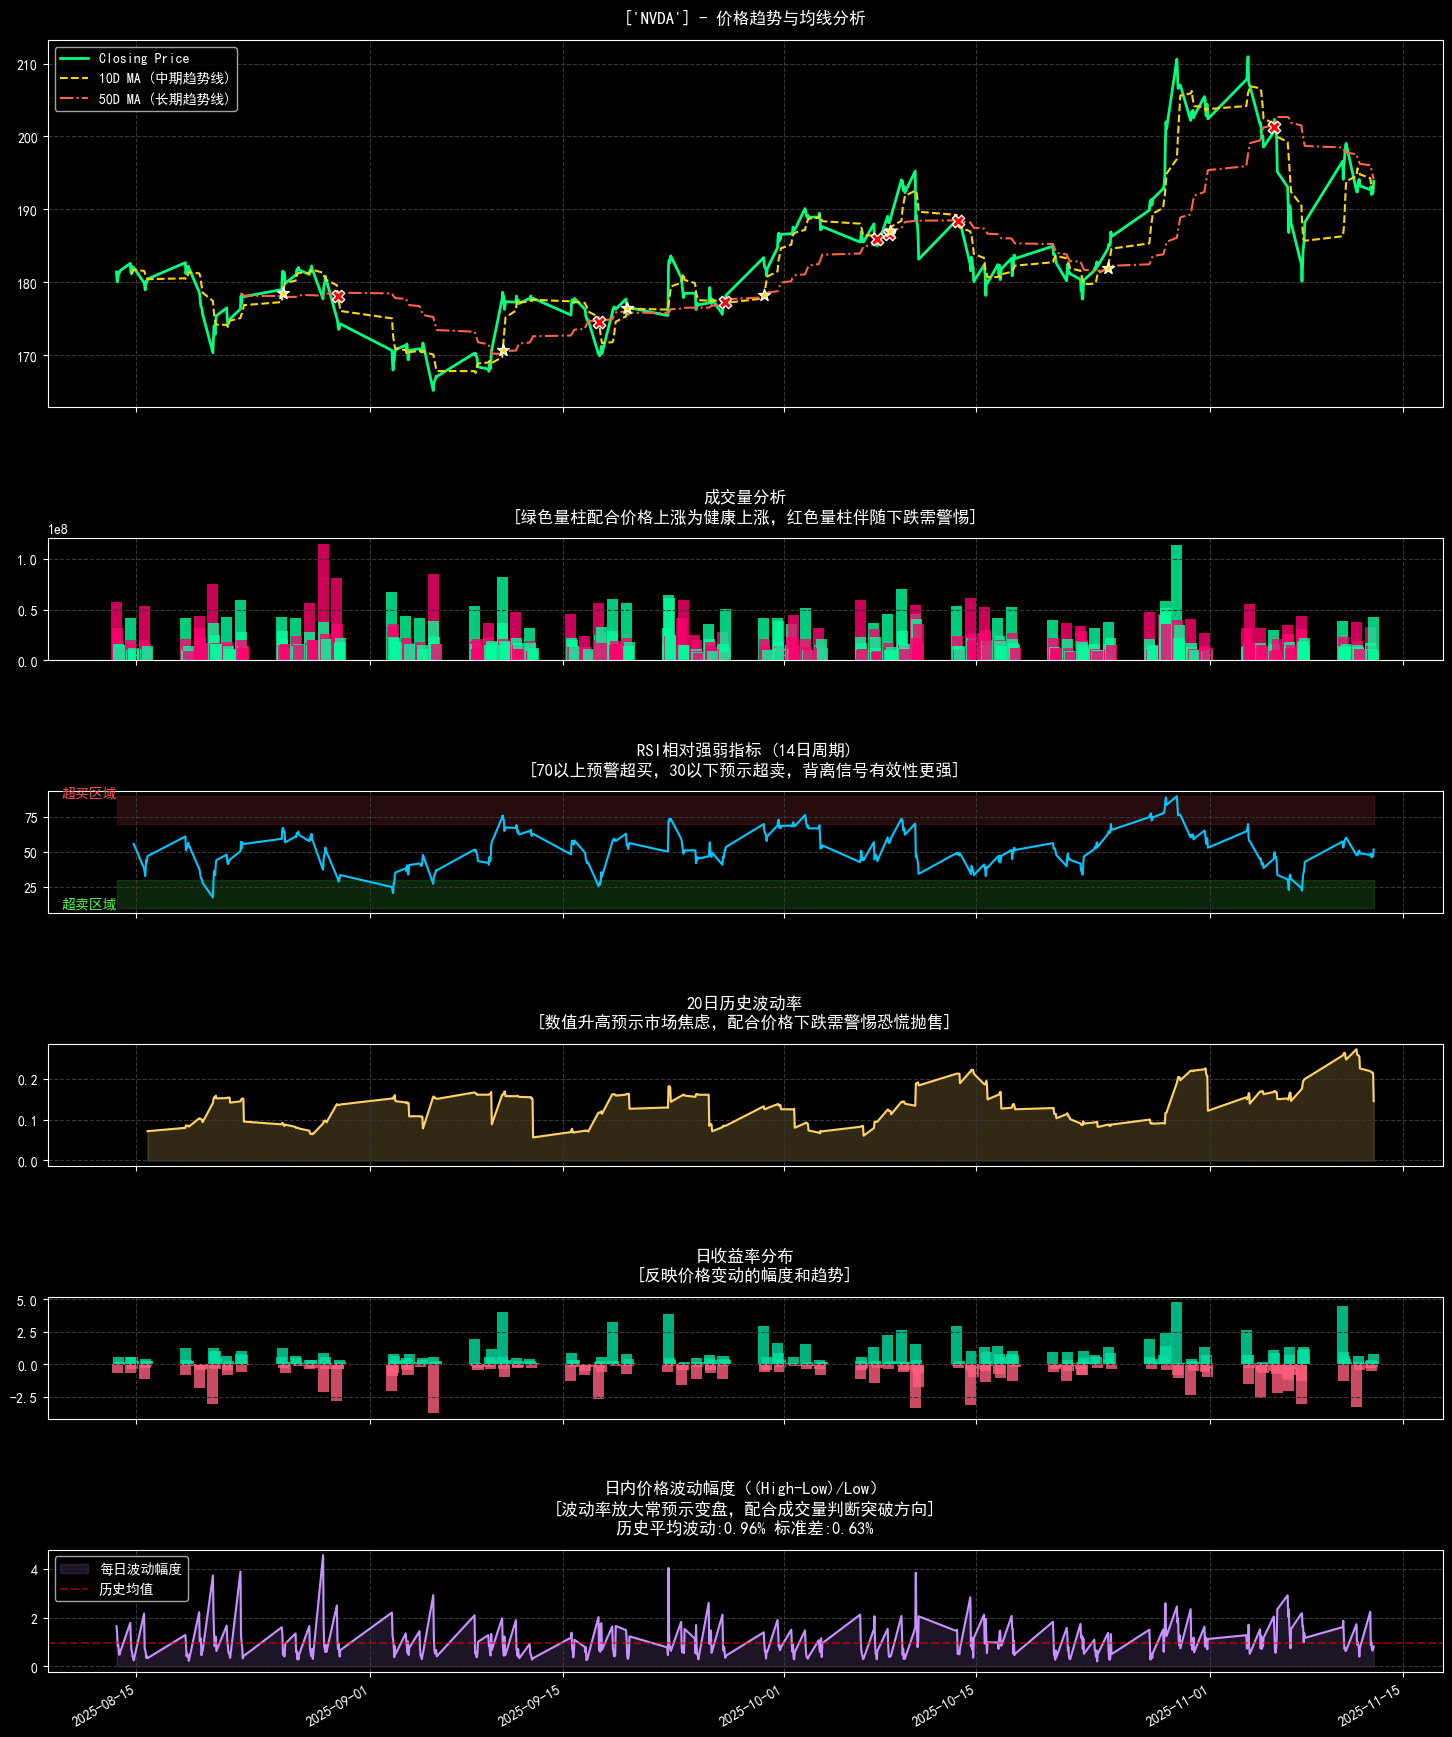

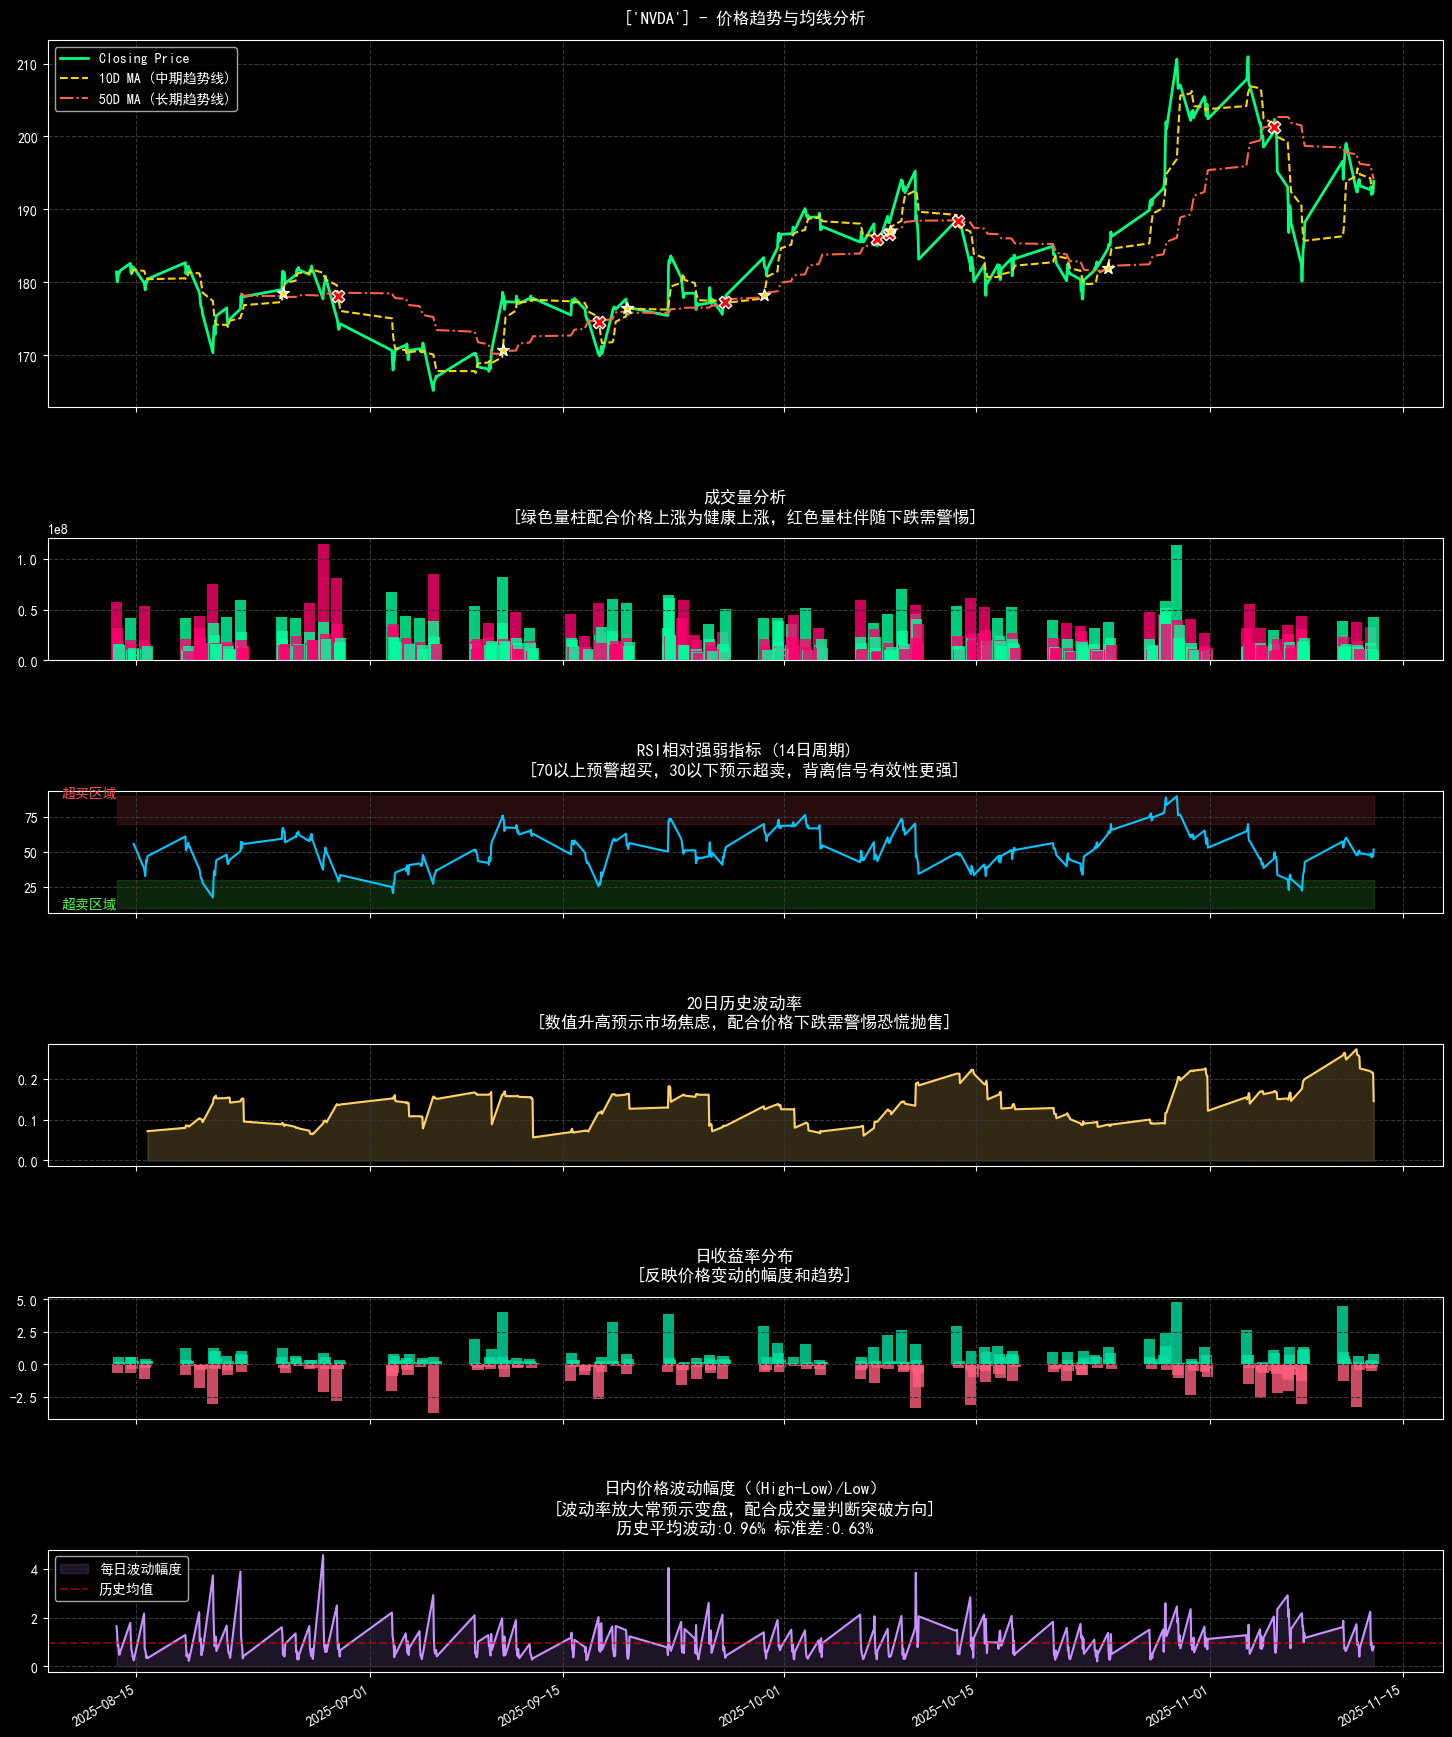

In [ ]:
plot_technical(df,ticker)

In [ ]:
def get_deepseek_analysis(df, model="deepseek-r1-250120"):
    """
    智能生成股票技术面分析报告和预测未来趋势
    输入：预处理后的美股数据
    输出：deepseek的回答，不包含思考过程
    """
    
    from dotenv import load_dotenv
    load_dotenv()
    # 1、股票数据
    latest = df
        # 提取元数据
    start_date = df.index.min()
    end_date = df.index.max()

    # 生成数据摘要
    data_summary = f"""
    收盘价范围：${df['Close'].min():.2f} - ${df['Close'].max():.2f}
    平均成交量：{df['Volume'].mean():,.0f} 手
    近期波动率：{df['Close'].pct_change().std():.2%}（过去20日）
    """
    
    # 步骤2：构建专业分析提示词
    analysis_prompt = f"""你是美股投资专家，这是{ticker}从{start_date}到{end_date}的交易数据，
    请用简单专业的语言分析{ticker[0]}的走势及其多/空投资机会（请在操作建议时，附上信心指数，<20不建议操作；20-40观望；40-60可以清仓，及时止损；60-80可以开始逐步建仓；>80强烈信号）：
    {latest}
    如果你认为提供更多技术指标会有帮助，请告诉我有哪些，我会补充。
    """
    
    # 步骤3：调用Deepseek API并解析结果
    # try:
    notebook_path = get_ipython().config["IPKernelApp"]["connection_file"].split("\\")[-2]
    project_root = Path(notebook_path).resolve().parent.parent# 动态构建项目路径 
    client = OpenAI(
            api_key='sk-svlwkvpmiesxltcrmogahgwdpsucauiqdvdrgssmogbtujvh',
            base_url='https://api.siliconflow.cn/v1'
            )
    
    completion = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=[
            {"role": "user", "content": analysis_prompt}
        ],
        max_tokens = 8192,
        temperature = 0.3
    )
    # 解析响应
    response_message = completion.choices[0].message

    # 提取回答和思考内容
    answer = response_message.content
    reasoning = response_message.reasoning_content

    # 格式化输出，只显示回答，不显示思考
    formatted_output = f'{answer.strip()}'

    output_file = "temp_output.md"
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("# DeepSeek 分析报告\n\n")
        f.write("## 数据摘要\n")
        f.write(data_summary + "\n\n")
        f.write("## 分析结果\n")
        f.write(formatted_output + "\n")
    os.system(f'code {output_file}')  # 在默认Markdown查看器中打开文件
    
    return print(data_summary + "\n" + formatted_output)
        
    # except Exception as e:
    #     print(f"模型调用失败: {str(e)}")
    #     return "暂无分析结果"

In [ ]:
message = get_deepseek_analysis(df)
print(message)
query_to_wechat.send_with_retry(message)


    收盘价范围：$165.14 - $210.96
    平均成交量：21,656,594 手
    近期波动率：0.91%（过去20日）
    
### NVDA走势分析（2025-08-13至2025-11-12）

#### **整体趋势**
- **价格表现**：开盘价$182.62 → 收盘价$193.85，**上涨6.1%**，但过程震荡明显，未形成单边趋势。
- **关键阻力**：$194-195区域（50日均线压制），**多次上攻失败**（如2025-11-12盘中高$193.90后回落）。
- **支撑位**：$191.50-$192.00（近期低点密集区）。

---

#### **技术指标信号**
1. **均线系统**：
   - **MA10持续低于MA50**（全周期未出现金叉），**空头排列**，中期趋势偏弱。
   - 最新MA10=$193.02，MA50=$194.15，价差-1.13（利空）。

2. **MACD**：
   - 最新值=-0.209，连续5日负值但**绿柱缩短**（下跌动能减弱），需观察是否形成金叉。

3. **RSI**：
   - 最新值=51.76（中性区域），无超买/超卖信号，方向指引有限。

4. **布林带**：
   - 价格紧贴**中轨下方**（$193.85 vs 中轨$194.18），上轨$198.55构成强压，下轨$189.80提供支撑。

5. **ADX**：
   - 最新值=14.03（<20），**趋势极弱**，市场处于震荡格局。

6. **成交量**：
   - 末期放量（如11-12 19:30成交4299万），但价格未突破，暗示抛压较重。

---

#### **多空操作建议**
1. **多头机会**：
   - **条件**：放量突破$194.15（MA50）并站稳，MACD金叉确认。
   - **目标**：$198.50（布林上轨）。
   - **止损**：$191.50（近期强支撑）。
   - **信心指数**：55（可轻仓试多，严格止损）。

2. **空头机会**：
   - **条件**：价格跌破$191.30（11-12低点），或反弹至$194附近遇阻。
   - **目标**：$189.80（布林下轨）。
   - **止损**

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MACD,Bollinger_High,Bollinger_Low,VWAP,ADX,Volume Profile,MA10_above_MA50
Datetime,,,,,,,,,,,,,,,,,,,
2025-08-13 13:30:00+00:00,182.615005,183.968994,180.979996,181.410995,57183001,NaN,NaN,1.651563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.119995,0.0,57183001,False
2025-08-13 14:30:00+00:00,181.395004,181.809296,179.350006,180.131805,31905250,-0.705134,-0.007076,1.371224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.514888,0.0,25277751,False
2025-08-13 15:30:00+00:00,180.139893,181.089996,179.574997,180.050003,18665334,-0.045413,-0.000454,0.843658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.293760,0.0,6612417,False
2025-08-13 16:30:00+00:00,180.039993,181.009995,179.399994,180.990005,15541217,0.522079,0.005207,0.897436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.189505,0.0,22153634,False
2025-08-13 17:30:00+00:00,180.979996,181.660004,180.470001,181.329895,13188042,0.187795,0.001876,0.659391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.186007,0.0,35341676,False


In [ ]:
def generate_report(ticker,start_date,end_date, period=None):
    import matplotlib.pyplot as plt
    
    df = download_stock_data([ticker], start_date, end_date, period)
    analysis_text = get_deepseek_analysis(df)
    fig = plot_technical(df,ticker)
    
    return plt.show(fig) ,analysis_text


In [ ]:
generate_report(ticker,start_date,end_date, period=period)

TypeError: expected string or bytes-like object, got 'list'